# Assignment 2 - Data from the web

## Data scraping

## 1. Obtain all the data

In [625]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import os
import os.path
import re
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup

The first thing to do is to get the base URL (basically looking at the address bar of the browser).
We need a second variable INDEX_PARAM because this page is using frames, and we'll need the base address to access them.

In [155]:
BASE_URL = "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm"
INDEX_PARAM = "ww_i_reportmodel=133685247"

Then let's fetch the parameters names, but as it is a bit tricker, BeautifulSoup will be a great help for this (and also some manual html inspection).

In [156]:
r = requests.get(BASE_URL + '?' + INDEX_PARAM)
soup = BeautifulSoup(r.text, 'html.parser')


#print(soup)

for frame in soup.find_all('frame'):
    if frame['name'] == 'toc':
        r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/" + frame['src'])
        print(frame['src'])
# The content of the frame

# Print slects
soup = BeautifulSoup(r.text, 'html.parser')
query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'
    


!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247


For convenience, we also create another function that builds the query from some desired parameters.

In [157]:
def build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason):
    # Print slects
    soup = BeautifulSoup(r.text, 'html.parser')
    query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'


    for in_put in soup.findAll('input'):
        #print (in_put['name'])
        if in_put.text == "xls":
        #print(in_put['value'])
            query = query + '&' + in_put['name'] + '=' + in_put['value']
     
    for select in soup.findAll('select'):
    #print (select['name'])
        for t in select.findAll('option'):
        #print(t)
            if t.text == section:
            #print(t['value'])
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == str(startYear) + '-' + str(endYear):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == semesterType + " " + str(semesterNumber):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == "Semestre " + semesterSeason:
                query = query + '&' + select['name'] + '=' + t['value']
    return query


And finally a nice function to easily query the EPFL page and get the data from it.

In [354]:
DATA_FOLDER_PATH = 'Data/'
COLUMNS_NAMES = ["civility", "name", "bachelor_orientation", "master_orientation", "specialisation", "optional_spec", "minor", "status", "exchange_type", "exchange_school", "sciper"]
def query_epfl(section, startYear, endYear, semesterType, semesterNumber, semesterSeason, update = False, writeToFile = True):
    #we create files to save the queries (and network bandwidth)
    path = str(section) + str(startYear) + str(endYear) + str(semesterType) + str(semesterNumber) + str(semesterSeason)
    
    #to avoid file naming issues
    path = re.sub('[^A-Za-z0-9]+', '', path)
    path += ".xls"
    
    df = None
    #we query the epfl server only if the file does not exist, or if we want to update the data
    if(not os.path.isfile(DATA_FOLDER_PATH + path) or update):
        queryString = build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason)
        response = requests.get(queryString, stream=True)
        if response.status_code == 200:
            data = pd.read_html(response.text, match='.+', flavor=None, header=1, index_col=None, skiprows=1)
            df = data[0]
            df.drop(df.columns[[11, 12]], axis=1, inplace=True) #remove useless columns (all are empty)
            df.columns = COLUMNS_NAMES
            
            #cleaning the invalid rows (basically mapping the scipers to real numbers and remove the non-number rows)
            scipers = df['sciper']
            df = df.drop('sciper', axis=1)
            df = df.join(scipers.apply(pd.to_numeric, errors='coerce'))
            df = df[~df.sciper.isnull()]
            
            if writeToFile:
                df.to_excel(DATA_FOLDER_PATH + path) #save to xls file
    else:
        df = pd.read_excel(DATA_FOLDER_PATH + path, sheetname=0, header=0)
    
    return df

We can now start using those functions to collect data. 
Example below:

In [355]:
test = query_epfl("Informatique", 2007,2008, "Bachelor semestre", 3, "d'automne")
test.head()

,civility,name,bachelor_orientation,master_orientation,specialisation,optional_spec,minor,status,exchange_type,exchange_school,sciper
0,Monsieur,Aapro Niccolò,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170617.0
1,Monsieur,Arn Patrick,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174454.0
2,Monsieur,Balas Martin,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174774.0
3,Monsieur,Bandelier Matthieu,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,173962.0
4,Monsieur,Bindschaedler Laurent,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170654.0


We're now going to collect and merge every single semester of every single year. We'll append columns "year", "semester".

Together with a student's sciper, we'll use this to make unique indexes. We could've used the name but it's possible that two students with the same name would be in the same class in the same year and semestre.

In [516]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 7):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Bachelor semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

bStudents = pd.concat(frames)
bStudents.shape

(5807, 13)

We make sure the index is unique

In [517]:
bStudents.index.is_unique

True

In [518]:
bStudents

civility                                  name  \
semester year sciper                                                   
1        2007 169569  Monsieur                     Arévalo Christian   
              174905  Monsieur                       Aubelle Flavien   
              173922  Monsieur                         Badoud Morgan   
              179406  Monsieur                    Baeriswyl Jonathan   
              179428  Monsieur                       Barroco Michael   
              179324  Monsieur                        Belfis Nicolas   
              174597  Monsieur                     Beliaev Stanislav   
              179449  Monsieur                 Bindschaedler Vincent   
              178553  Monsieur                    Bloch Marc-Olivier   
              179426  Monsieur                            Bloch Remi   
              178271  Monsieur                Boéchat Marc-Alexandre   
              182433  Monsieur                        Böhler Michael   
              180731  Monsieur                  Bricola Jean-Charles   
              171619  Monsieur                  Buchschacher Nicolas   
              179837  Monsieur                          Caloz Daniel   
              179157  Monsieur                        Calvert Thomas   
              179864  Monsieur                      Cambazard Thomas   
              174590  Monsieur                   Camenzind Guillaume   
              178843  Monsieur                        Cattin Nicolas   
              178711  Monsieur                          Cino Emanuel   
              178786  Monsieur                          Coiro Andrea   
              179567  Monsieur                     Collavini Gregory   
              176282  Monsieur                        Corbat Nicolas   
              178656  Monsieur                     Curreli Alexandre   
              181445  Monsieur                        Custovic Alain   
              178718  Monsieur                      Dal Mas Gianluca   
              175466  Monsieur                     Decorvet Grégoire   
              173882  Monsieur                     Dettwiler Fabrice   
              181612    Madame                     Ej-Jennane Jihane   
              181232  Monsieur                        Epiney Vincent   
...                        ...                                   ...   
5        2016 247891  Monsieur                        Weier Philippe   
              250410  Monsieur                           Wicht Bruno   
              212826  Monsieur                       Willemin Xavier   
              250419  Monsieur                  Wütschert Robin Axel   
              237151  Monsieur                  Zbinden Boris Adrien   
              226652  Monsieur                 Zenhäusern Joey Kevin   
6        2016 246671  Monsieur                    Abate Bryan Jeremy   
              251759  Monsieur                     Alami-Idrissi Ali   
              249498  Monsieur                         Aoun Leonardo   
              234551  Monsieur              Bachmann Roman Christian   
              247328  Monsieur                  Beck Johannes Magnus   
              251758  Monsieur                          Benlalah Ali   
              250300  Monsieur              Bovel Matthieu Alexandre   
              249954  Monsieur      Burgelin Clément Louis Alexandre   
              249996  Monsieur                  Coudert Rémi Edouard   
              239489    Madame                       Evrova Gabriela   
              246663  Monsieur                   Haefeli Simon Lucas   
              245511  Monsieur                         Lamonato Yves   
              250703  Monsieur              Madillo Raphael Frederic   
              245512  Monsieur             Massemin Lucas Christophe   
              247855  Monsieur     Mösching Guillaume Edouard Albert   
              227311    Madame  Mollier Lauriane Catherine Emilienne   
              245782  Monsieur                        Perret T

With this very nice table, we still need the keep the students present in semester 1 and semester 6 only.

In [684]:
bStudentsS1toS6 = pd.merge(bStudents.loc[1], bStudents.loc[6], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S6'))
bStudentsS1toS6 = bStudentsS1toS6[['civility', 'sciper', 'year_S1', 'year_S6']] #only retain the important fields
bStudentsS1toS6['ydiff'] = bStudentsS1toS6['year_S6'] - bStudentsS1toS6['year_S1']

bStudentsS1toS6 = bStudentsS1toS6.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.ydiff.idxmax()])
bStudentsS1toS6.set_index('sciper', inplace=True)
bStudentsS1toS6

,civility,year_S1,year_S6,ydiff
sciper,,,,
147008,Monsieur,2008,2010,2
169569,Monsieur,2007,2009,2
169731,Monsieur,2007,2010,3
169795,Monsieur,2007,2010,3
171195,Monsieur,2007,2009,2
171619,Monsieur,2007,2009,2
174905,Monsieur,2007,2011,4
175190,Monsieur,2007,2009,2
175280,Monsieur,2007,2010,3


Quick check before proceeding

In [670]:
bStudentsS1toS6.index.is_unique

True

Now we are certain that our dataset is well formed, and thus start to analyze it.
We begin by grouping the students by their graduation time.

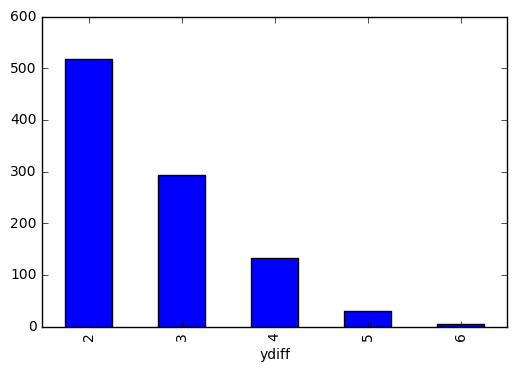

In [681]:
bStudentsS1toS6_grp = bStudentsS1toS6.groupby(bStudentsS1toS6.ydiff)
bStudentsS1toS6_grp['ydiff'].sum().plot.bar()

Here we see that most of the students made it in minimal time, which is 3 years.
Some made it in 7 years, that is normaly not possible but it is possible that some students had health problems and could do the exams the next year.